### Timing

* Point in time: Day of week, Month of year, Time of day
* Durations: time from launch to deadline
* Goal: Advise people when to launch so that the project will reach its goal and become successful

EDA - get an overview: 
- [x] Relevant columns for me
- [x] Dataframe x & y 
- [x] correlation
- [x] boxplot
- [x] distplot

Simple model
- [x] Log regression

Clarify
- [x] Regularization needed?

Fancy model
- [ ] Decision tree
- [ ] Random forrest

In [263]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Suppress warnings 
# (sometimes you might want to ignore warnings, that's how you can achieve this)
import warnings
warnings.filterwarnings('ignore')

RSEED = 42

In [200]:
df_raw = pd.read_csv('data/2_data.csv')

In [201]:
columns = ['state', 'date_creation', 'date_end', 'date_launch', 'duration']
df = df_raw[columns].copy()

In [202]:
#splitting date columns 
df[['date_creation', 'date_cree_time']] = df['date_creation'].str.split(' ', expand=True)
df[['date_end', 'date_end_time']] = df['date_end'].str.split(' ', expand=True)
df[['date_launch', 'date_launch_time']] = df['date_launch'].str.split(' ', expand=True)
df[['duration', 'duration_days_weeks', 'duration_time']] = df['duration'].str.split(' ', expand=True)

#deleting not necessary extra columns with time
df = df.drop('duration_days_weeks', axis = 1).drop('duration_time', axis = 1).drop('date_launch_time', axis = 1).drop('date_end_time', axis = 1).drop('date_cree_time', axis = 1)

#changing dtype from object to datetime
col_time = ['date_creation', 'date_end', 'date_launch']
for date in col_time:
    df[date] = pd.to_datetime(df[date]) # convert to datetime


In [203]:
#replace state --> failed == 0 and successfull == 1
df['state'] = df['state'].replace('failed', 0).replace('successful', 1).astype(int)

#change dtype for duration from object into int
df.duration = df.duration.astype(int)

In [204]:
df['weekday_launch'] = df.date_launch.dt.dayofweek
df['month_launch'] = df.date_launch.dt.month
df['weekday_end'] = df.date_end.dt.dayofweek
df['month_end'] = df.date_end.dt.month

#weekday 1 to 7, and not 0 - 6 anymore
df['weekday_launch'] = df.weekday_launch.replace(6,7).replace(5,6).replace(4,5).replace(3,4).replace(2,3).replace(1,2).replace(0,1)

In [205]:
df

,state,date_creation,date_end,date_launch,duration,weekday_launch,month_launch,weekday_end,month_end
0,1,2017-08-02,2017-09-09,2017-08-10,30,4,8,5,9
1,1,2012-09-30,2013-06-12,2013-05-13,30,1,5,2,6
2,0,2017-01-07,2017-03-13,2017-01-12,59,4,1,0,3
3,1,2012-12-06,2013-01-09,2012-12-10,30,1,12,2,1
4,1,2014-10-24,2015-05-02,2015-04-02,30,4,4,5,5
...,...,...,...,...,...,...,...,...,...
168974,1,2014-07-17,2014-10-01,2014-08-04,58,1,8,2,10
168975,1,2017-04-24,2017-06-19,2017-05-14,36,7,5,0,6
168976,1,2012-07-03,2012-09-17,2012-08-14,33,2,8,0,9
168977,1,2015-03-02,2015-04-20,2015-03-21,30,6,3,0,4


# EDA

In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168979 entries, 0 to 168978
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   state           168979 non-null  int64         
 1   date_creation   168979 non-null  datetime64[ns]
 2   date_end        168979 non-null  datetime64[ns]
 3   date_launch     168979 non-null  datetime64[ns]
 4   duration        168979 non-null  int64         
 5   weekday_launch  168979 non-null  int64         
 6   month_launch    168979 non-null  int64         
 7   weekday_end     168979 non-null  int64         
 8   month_end       168979 non-null  int64         
dtypes: datetime64[ns](3), int64(6)
memory usage: 11.6 MB


### weekdays

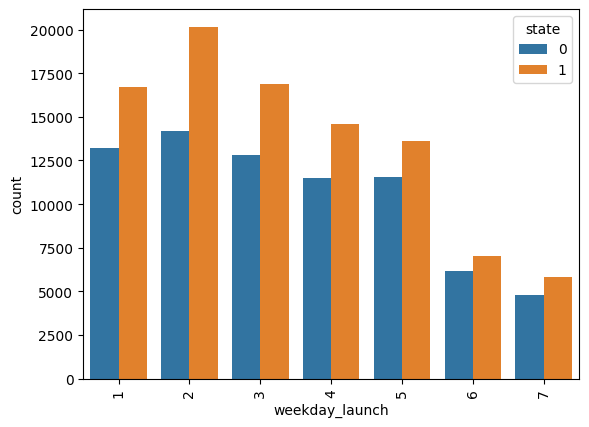

In [207]:
b = sns.countplot(data=df, x='weekday_launch', hue='state')
b.set_xticklabels(b.get_xticklabels(),rotation = 90, size = 10)
plt.show()

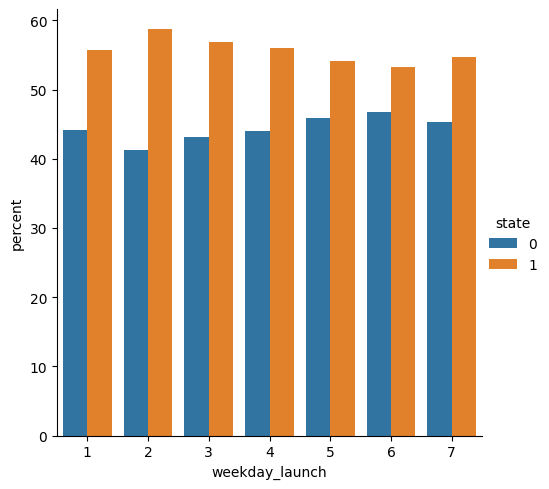

In [208]:
x,y = 'weekday_launch', 'state'

(df
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'));

### overview - duration

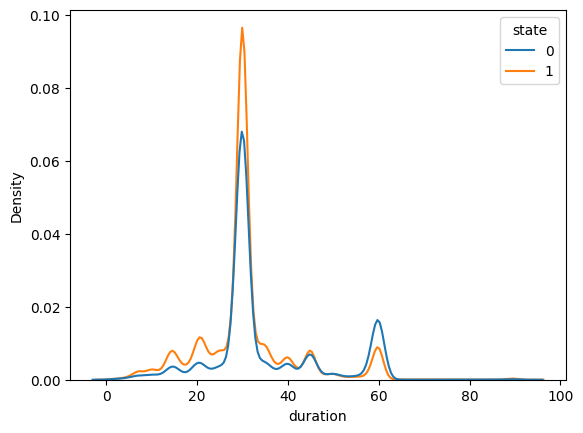

In [209]:
#sns.displot(data=df, x='duration', hue='state', kind = 'kde');
sns.kdeplot(data=df, x="duration", hue="state");

In [210]:
print('min. duration time in data ', df.duration.min())
print('max. duration time in data ', df.duration.max())

min. duration time in data  1
max. duration time in data  93


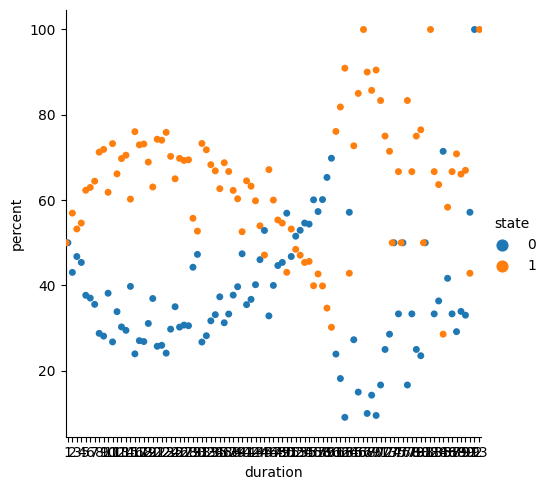

In [211]:
x,y = 'duration', 'state'

(df
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y, kind = 'swarm'));

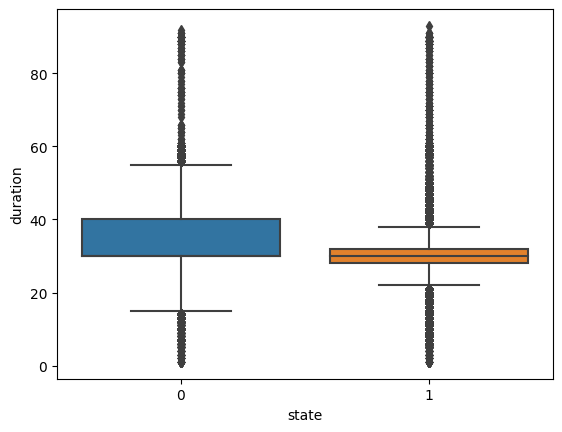

In [212]:
sns.boxplot(y = df['duration'], x = df['state']);

### month

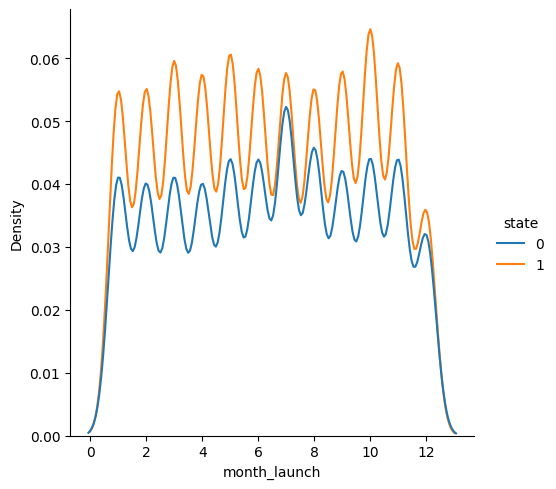

In [213]:
sns.displot(data=df, x='month_launch', hue='state', kind = 'kde');

### correlation

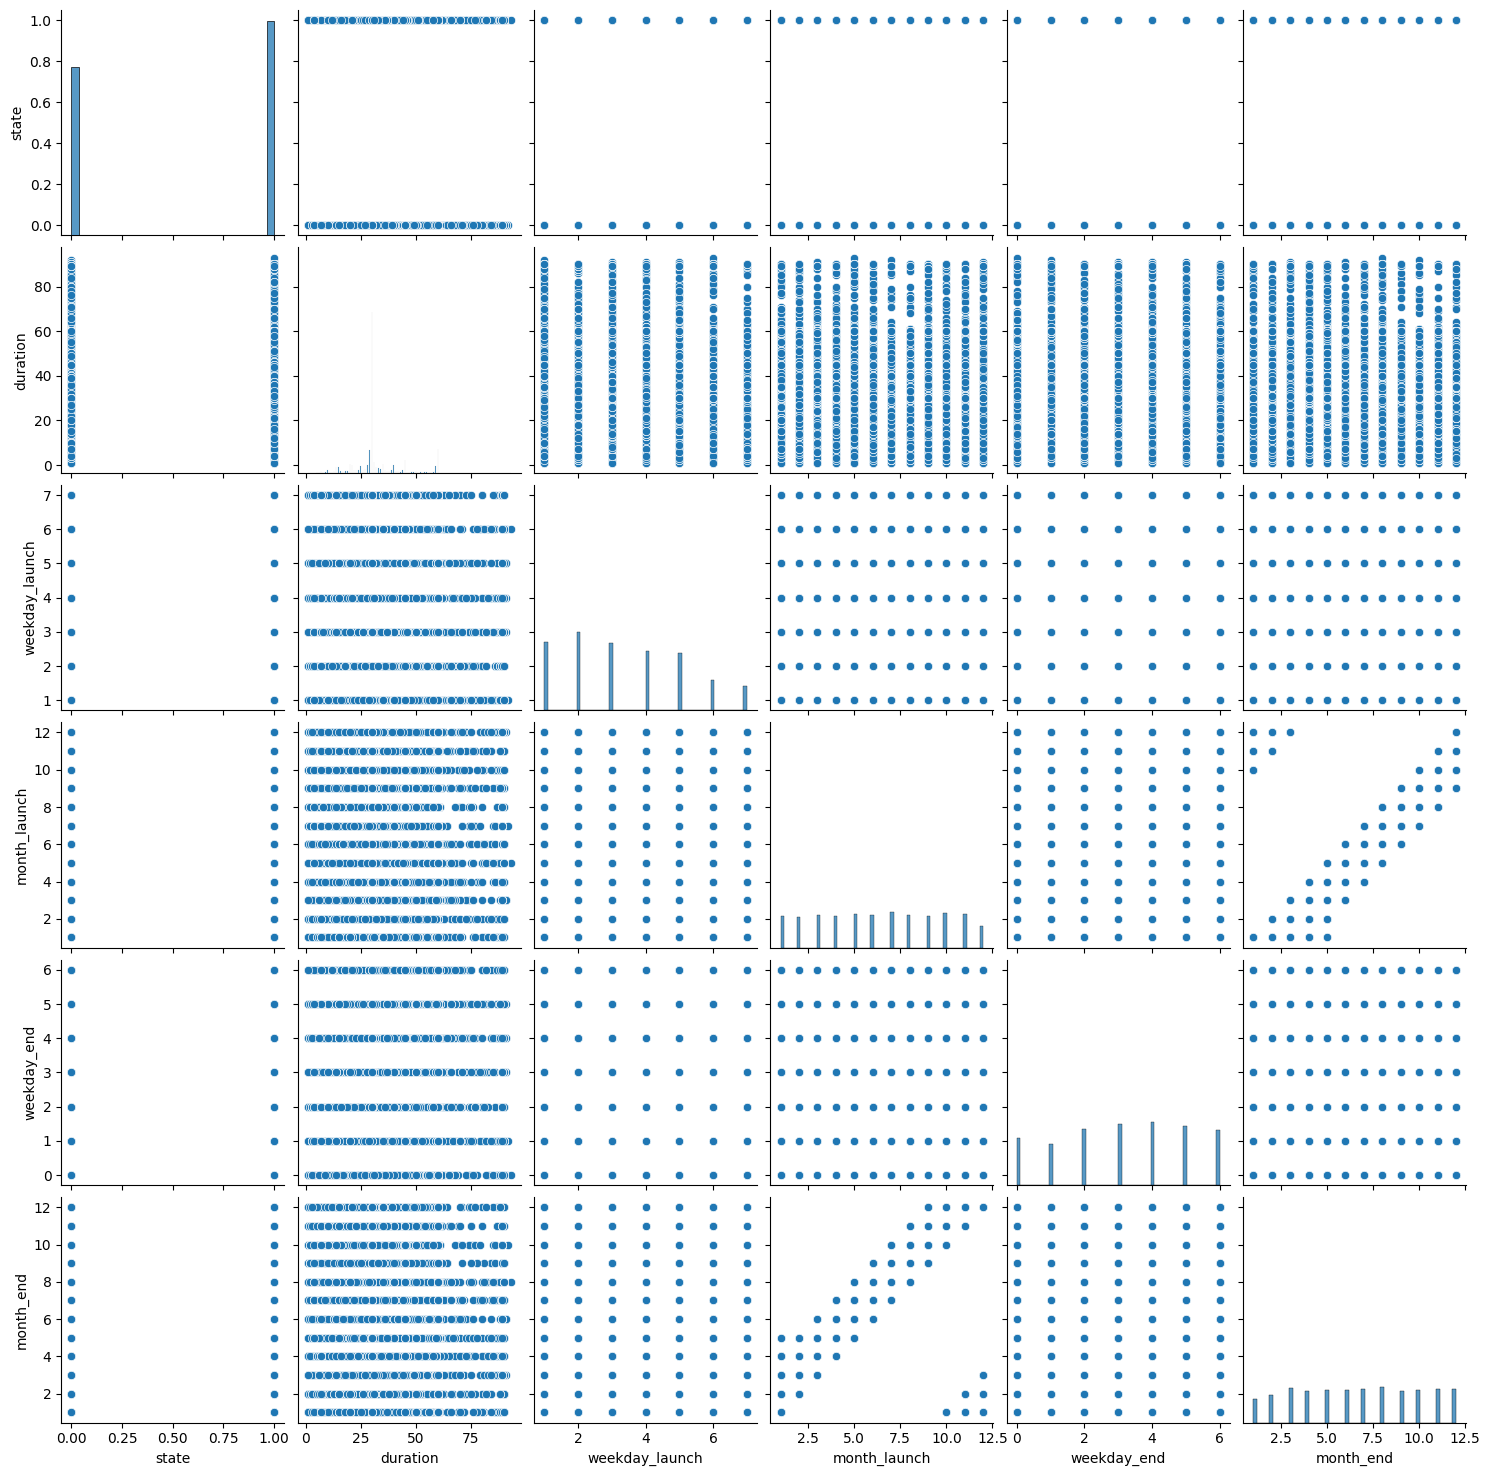

In [223]:
sns.pairplot(data = df)

In [219]:
#additional dataframe for a heatmap - didn't work
# df_wo_date = df.copy()
# df_wo_date = df_wo_date.drop('date_creation', axis = 1).drop('date_end', axis = 1).drop('date_launch', axis = 1)
# sns.heatmap(df_wo_date, annot=True)

In [227]:
df.corr()

,state,duration,weekday_launch,month_launch,weekday_end,month_end
state,1.000000,-0.153926,-0.022763,-0.013544,-0.017677,0.000879
duration,-0.153926,1.000000,0.013229,0.018764,0.022608,-0.016753
weekday_launch,-0.022763,0.013229,1.000000,-0.011486,-0.008721,-0.017088
month_launch,-0.013544,0.018764,-0.011486,1.000000,-0.005491,0.619723
weekday_end,-0.017677,0.022608,-0.008721,-0.005491,1.000000,-0.000887
month_end,0.000879,-0.016753,-0.017088,0.619723,-0.000887,1.000000


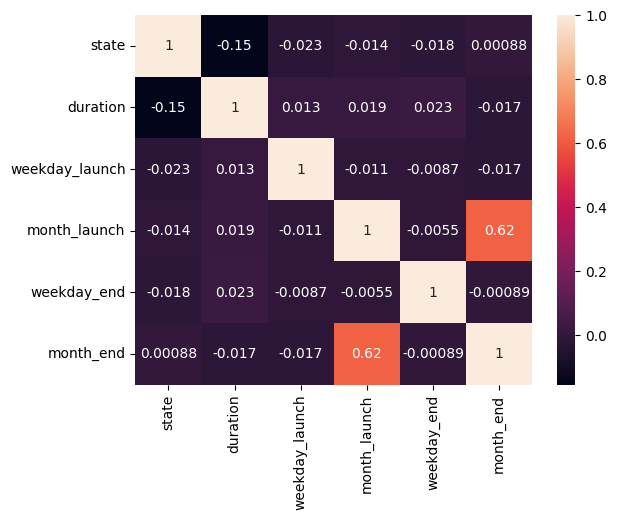

In [292]:
#correlation plot
ax = sns.heatmap(df.corr(), annot=True)

# Simple model

In [229]:
# Defining target and predictors 
y = df['state'] #target
X = df.drop('state', axis = 1).drop('date_creation', axis = 1).drop('date_end', axis = 1).drop('date_launch', axis = 1) #predictors

In [233]:
# Train-test-split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RSEED)

In [234]:
# Scaling with MinMaxScaler
minmax = MinMaxScaler()
X_train_scaled = minmax.fit_transform(X_train)
X_test_scaled = minmax.transform(X_test)

In [235]:
# Modelling
logistic_regression = LogisticRegression(max_iter=200)
logistic_regression.fit(X_train_scaled, y_train)
y_pred = logistic_regression.predict(X_test_scaled)

In [236]:
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))

Accuracy:  0.5879512368327613


classification_report: 
              precision    recall  f1-score   support

           0       0.57      0.22      0.32     18431
           1       0.59      0.87      0.70     23814

    accuracy                           0.59     42245
   macro avg       0.58      0.55      0.51     42245
weighted avg       0.58      0.59      0.54     42245



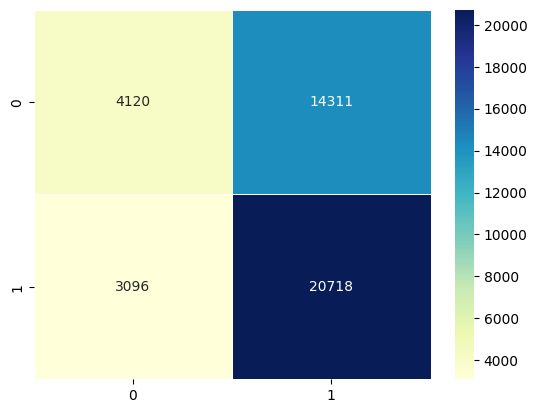

In [240]:
# Confusion matrix using confusion_matrix from sklearn
cfm = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(cfm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

print ('classification_report: ')
print (metrics.classification_report(y_test, y_pred))

In [257]:
#function for the whole process

def simple_model(X,y,RSEED = 42):
    # Train-test-split 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RSEED)
    # Scaling with MinMaxScaler
    minmax = MinMaxScaler()
    X_train_scaled = minmax.fit_transform(X_train)
    X_test_scaled = minmax.transform(X_test)
    # Modelling
    logistic_regression = LogisticRegression(max_iter=200)
    logistic_regression.fit(X_train_scaled, y_train)
    y_pred = logistic_regression.predict(X_test_scaled)
    print('[simple model WITH scaler]')
    print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
    # Confusion matrix using confusion_matrix from sklearn
    cfm = metrics.confusion_matrix(y_test, y_pred)
    print(sns.heatmap(cfm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5))
    print ('classification_report: ')
    print (metrics.classification_report(y_test, y_pred))

### simple model with less features

Accuracy:  0.5884009942004971
AxesSubplot(0.125,0.11;0.62x0.77)
classification_report: 
              precision    recall  f1-score   support

           0       0.57      0.22      0.32     18431
           1       0.59      0.87      0.70     23814

    accuracy                           0.59     42245
   macro avg       0.58      0.55      0.51     42245
weighted avg       0.58      0.59      0.54     42245



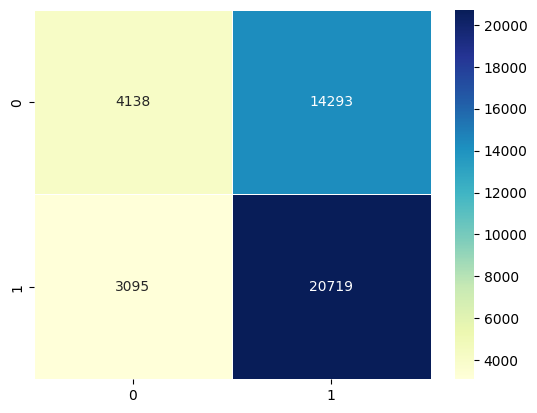

In [251]:
#DELETE month_end and weekday_end
# Defining target and predictors 
y = df['state'] #target
X = df.drop('state', axis = 1).drop('date_creation', axis = 1).drop('date_end', axis = 1).drop('date_launch', axis = 1).drop('month_end', axis = 1).drop('weekday_end', axis = 1) #predictors

simple_model(X,y)

In [258]:
#function process without scaler

def simple_model_wo_scaler(X,y,RSEED = 42):
    # Train-test-split 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RSEED)
    # Modelling
    logistic_regression = LogisticRegression(max_iter=200)
    logistic_regression.fit(X_train, y_train)
    y_pred = logistic_regression.predict(X_test)
    print('[simple model WITHOUT scaler]')
    print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
    # Confusion matrix using confusion_matrix from sklearn
    cfm = metrics.confusion_matrix(y_test, y_pred)
    print(sns.heatmap(cfm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5))
    print ('classification_report: ')
    print (metrics.classification_report(y_test, y_pred))

### simple model only state and duration

[simple model WITH scaler]
Accuracy:  0.5884009942004971
AxesSubplot(0.125,0.11;0.62x0.77)
classification_report: 
              precision    recall  f1-score   support

           0       0.57      0.22      0.32     18431
           1       0.59      0.87      0.71     23814

    accuracy                           0.59     42245
   macro avg       0.58      0.55      0.51     42245
weighted avg       0.58      0.59      0.54     42245

[simple model WITHOUT scaler]
Accuracy:  0.5884009942004971
AxesSubplot(0.125,0.11;0.496x0.77)
classification_report: 
              precision    recall  f1-score   support

           0       0.57      0.22      0.32     18431
           1       0.59      0.87      0.71     23814

    accuracy                           0.59     42245
   macro avg       0.58      0.55      0.51     42245
weighted avg       0.58      0.59      0.54     42245



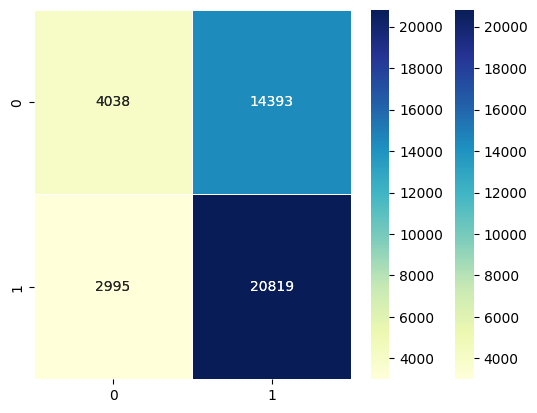

In [259]:
y = df['state'] #target
X = df[['duration']] #predictor

simple_model(X,y)
simple_model_wo_scaler(X,y)

### simple model only state and weekday_launch

[simple model WITH scaler]
Accuracy:  0.563711681855841
AxesSubplot(0.125,0.11;0.62x0.77)
classification_report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     18431
           1       0.56      1.00      0.72     23814

    accuracy                           0.56     42245
   macro avg       0.28      0.50      0.36     42245
weighted avg       0.32      0.56      0.41     42245

[simple model WITHOUT scaler]
Accuracy:  0.563711681855841
AxesSubplot(0.125,0.11;0.496x0.77)
classification_report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     18431
           1       0.56      1.00      0.72     23814

    accuracy                           0.56     42245
   macro avg       0.28      0.50      0.36     42245
weighted avg       0.32      0.56      0.41     42245



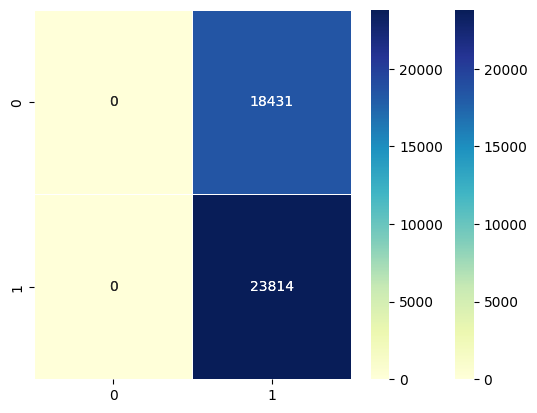

In [261]:
y = df['state'] #target
X = df[['weekday_launch']] #predictor

simple_model(X,y)
simple_model_wo_scaler(X,y)

### simple model only state and weekday_end

[simple model WITH scaler]
Accuracy:  0.563711681855841
AxesSubplot(0.125,0.11;0.62x0.77)
classification_report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     18431
           1       0.56      1.00      0.72     23814

    accuracy                           0.56     42245
   macro avg       0.28      0.50      0.36     42245
weighted avg       0.32      0.56      0.41     42245

[simple model WITHOUT scaler]
Accuracy:  0.563711681855841
AxesSubplot(0.125,0.11;0.496x0.77)
classification_report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     18431
           1       0.56      1.00      0.72     23814

    accuracy                           0.56     42245
   macro avg       0.28      0.50      0.36     42245
weighted avg       0.32      0.56      0.41     42245



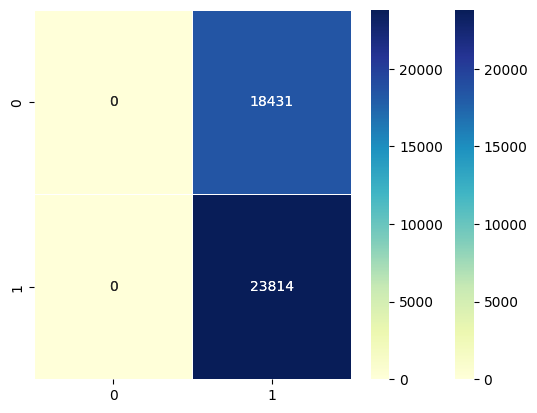

In [262]:
y = df['state'] #target
X = df[['weekday_end']] #predictor

simple_model(X,y)
simple_model_wo_scaler(X,y)

# Fancy model

## decision tree

In [265]:
# function for decision tree modelling WITHOUT scaler
def decision_tree(X,y,RSEED = 42):
    #train-test-split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RSEED, stratify=y)

    #define model
    clf_gini = DecisionTreeClassifier()

    #modelling
    clf_gini.fit(X_train, y_train)

    #predict with "test" data
    y_pred = clf_gini.predict(X_test)

    #just for fun
    y_pred_train = clf_gini.predict(X_train)

    #print accuracy for test and train data
    print('model WITHOUT scaler')
    print('Accuracy on test data: ', round(metrics.accuracy_score(y_test, y_pred), 2))
    print('Accuracy on train data: ', round(metrics.accuracy_score(y_train, y_pred_train), 2))

    #classification report
    print(classification_report(y_test, y_pred))

    #confusion matrix using pandas crosstab
    confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['actual'], colnames=['predicted'])
    print(confusion_matrix)

In [269]:
# function for decision tree modelling WITH scaler
def decision_tree_scaler(X,y,RSEED = 42):
        #train-test-split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RSEED, stratify=y)

    # Scaling with MinMaxScaler
    minmax = MinMaxScaler()
    X_train = minmax.fit_transform(X_train)
    X_test = minmax.transform(X_test)
    
    #define model
    clf_gini = DecisionTreeClassifier()

    #modelling
    clf_gini.fit(X_train, y_train)

    #predict with "test" data
    y_pred = clf_gini.predict(X_test)

    #just for fun
    y_pred_train = clf_gini.predict(X_train)

    #print accuracy for test and train data
    print('model WITH scaler')
    print('Accuracy on test data: ', round(metrics.accuracy_score(y_test, y_pred), 2))
    print('Accuracy on train data: ', round(metrics.accuracy_score(y_train, y_pred_train), 2))

    #classification report
    print(classification_report(y_test, y_pred))

    #confusion matrix using pandas crosstab
    confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['actual'], colnames=['predicted'])
    print(confusion_matrix)

In [270]:
#define X and y - columns without date type
y = df['state'] #target
X = df.drop('state', axis = 1).drop('date_creation', axis = 1).drop('date_end', axis = 1).drop('date_launch', axis = 1) #predictors

#run the models
decision_tree(X,y)
decision_tree_scaler(X,y)


model WITHOUT scaler
Accuracy on test data:  0.58
Accuracy on train data:  0.64
              precision    recall  f1-score   support

           0       0.53      0.40      0.46     18550
           1       0.61      0.72      0.66     23695

    accuracy                           0.58     42245
   macro avg       0.57      0.56      0.56     42245
weighted avg       0.57      0.58      0.57     42245

predicted     0      1
actual                
0          7501  11049
1          6742  16953
model WITH scaler
Accuracy on test data:  0.58
Accuracy on train data:  0.64
              precision    recall  f1-score   support

           0       0.53      0.40      0.46     18550
           1       0.61      0.72      0.66     23695

    accuracy                           0.58     42245
   macro avg       0.57      0.56      0.56     42245
weighted avg       0.57      0.58      0.57     42245

predicted     0      1
actual                
0          7491  11059
1          6733  16962


In [271]:
#define X and y - columns without date type, and without end_weekday + _month
y = df['state'] #target
X = df.drop('state', axis = 1).drop('date_creation', axis = 1).drop('date_end', axis = 1).drop('date_launch', axis = 1).drop('month_end', axis = 1).drop('weekday_end', axis = 1) #predictors

#run the models
decision_tree(X,y)
decision_tree_scaler(X,y)

model WITHOUT scaler
Accuracy on test data:  0.59
Accuracy on train data:  0.62
              precision    recall  f1-score   support

           0       0.55      0.35      0.43     18550
           1       0.61      0.78      0.68     23695

    accuracy                           0.59     42245
   macro avg       0.58      0.56      0.56     42245
weighted avg       0.58      0.59      0.57     42245

predicted     0      1
actual                
0          6573  11977
1          5328  18367
model WITH scaler
Accuracy on test data:  0.59
Accuracy on train data:  0.62
              precision    recall  f1-score   support

           0       0.55      0.35      0.43     18550
           1       0.61      0.78      0.68     23695

    accuracy                           0.59     42245
   macro avg       0.58      0.56      0.56     42245
weighted avg       0.58      0.59      0.57     42245

predicted     0      1
actual                
0          6572  11978
1          5329  18366


In [272]:
#define X and y - only state and duration
y = df['state'] #target
X = df[['duration']] #predictors

#run the models
decision_tree(X,y)
decision_tree_scaler(X,y)

model WITHOUT scaler
Accuracy on test data:  0.6
Accuracy on train data:  0.6
              precision    recall  f1-score   support

           0       0.64      0.20      0.30     18550
           1       0.59      0.91      0.72     23695

    accuracy                           0.60     42245
   macro avg       0.61      0.55      0.51     42245
weighted avg       0.61      0.60      0.53     42245

predicted     0      1
actual                
0          3634  14916
1          2083  21612
model WITH scaler
Accuracy on test data:  0.6
Accuracy on train data:  0.6
              precision    recall  f1-score   support

           0       0.64      0.20      0.30     18550
           1       0.59      0.91      0.72     23695

    accuracy                           0.60     42245
   macro avg       0.61      0.55      0.51     42245
weighted avg       0.61      0.60      0.53     42245

predicted     0      1
actual                
0          3634  14916
1          2083  21612


In [273]:
#define X and y - only state and weekday_launch
y = df['state'] #target
X = df[['weekday_launch']] #predictors

#run the models
decision_tree(X,y)
decision_tree_scaler(X,y)

model WITHOUT scaler
Accuracy on test data:  0.56
Accuracy on train data:  0.56
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     18550
           1       0.56      1.00      0.72     23695

    accuracy                           0.56     42245
   macro avg       0.28      0.50      0.36     42245
weighted avg       0.31      0.56      0.40     42245

predicted      1
actual          
0          18550
1          23695
model WITH scaler
Accuracy on test data:  0.56
Accuracy on train data:  0.56
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     18550
           1       0.56      1.00      0.72     23695

    accuracy                           0.56     42245
   macro avg       0.28      0.50      0.36     42245
weighted avg       0.31      0.56      0.40     42245

predicted      1
actual          
0          18550
1          23695


In [274]:
#define X and y - only state and month_launch
y = df['state'] #target
X = df[['month_launch']] #predictors

#run the models
decision_tree(X,y)
decision_tree_scaler(X,y)

model WITHOUT scaler
Accuracy on test data:  0.56
Accuracy on train data:  0.56
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     18550
           1       0.56      1.00      0.72     23695

    accuracy                           0.56     42245
   macro avg       0.28      0.50      0.36     42245
weighted avg       0.31      0.56      0.40     42245

predicted      1
actual          
0          18550
1          23695
model WITH scaler
Accuracy on test data:  0.56
Accuracy on train data:  0.56
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     18550
           1       0.56      1.00      0.72     23695

    accuracy                           0.56     42245
   macro avg       0.28      0.50      0.36     42245
weighted avg       0.31      0.56      0.40     42245

predicted      1
actual          
0          18550
1          23695


In [275]:
#define X and y - state, weekday_launch and month_launch
y = df['state'] #target
X = df[['duration', 'weekday_launch', 'month_launch']] #predictors

#run the models
decision_tree(X,y)
decision_tree_scaler(X,y)

model WITHOUT scaler
Accuracy on test data:  0.59
Accuracy on train data:  0.62
              precision    recall  f1-score   support

           0       0.55      0.35      0.43     18550
           1       0.61      0.78      0.68     23695

    accuracy                           0.59     42245
   macro avg       0.58      0.56      0.56     42245
weighted avg       0.58      0.59      0.57     42245

predicted     0      1
actual                
0          6573  11977
1          5330  18365
model WITH scaler
Accuracy on test data:  0.59
Accuracy on train data:  0.62
              precision    recall  f1-score   support

           0       0.55      0.35      0.43     18550
           1       0.61      0.78      0.68     23695

    accuracy                           0.59     42245
   macro avg       0.58      0.56      0.56     42245
weighted avg       0.58      0.59      0.57     42245

predicted     0      1
actual                
0          6571  11979
1          5328  18367


## random forest

In [283]:
# function for decision tree modelling WITH scaler
def random_forest(X,y,RSEED = 42):
        #train-test-split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RSEED, stratify=y)
    
    #define model
    dr = RandomForestClassifier(random_state=RSEED)

    #modelling
    dr.fit(X_train, y_train)

    #predict with "test" data
    y_pred = dr.predict(X_test)

    #just for fun
    y_pred_train = dr.predict(X_train)

    #print accuracy for test and train data
    print('model WITH scaler')
    print('Accuracy on test data: ', round(metrics.accuracy_score(y_test, y_pred), 2))
    print('Accuracy on train data: ', round(metrics.accuracy_score(y_train, y_pred_train), 2))

    #classification report
    print(classification_report(y_test, y_pred))

    #confusion matrix using pandas crosstab
    confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['actual'], colnames=['predicted'])
    print(confusion_matrix)

In [284]:
# function for decision tree modelling WITH scaler
def random_forest_scaler(X,y,RSEED = 42):
        #train-test-split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RSEED, stratify=y)

    # Scaling with MinMaxScaler
    minmax = MinMaxScaler()
    X_train = minmax.fit_transform(X_train)
    X_test = minmax.transform(X_test)
    
    #define model
    dr = RandomForestClassifier(random_state=RSEED)

    #modelling
    dr.fit(X_train, y_train)

    #predict with "test" data
    y_pred = dr.predict(X_test)

    #just for fun
    y_pred_train = dr.predict(X_train)

    #print accuracy for test and train data
    print('model WITH scaler')
    print('Accuracy on test data: ', round(metrics.accuracy_score(y_test, y_pred), 2))
    print('Accuracy on train data: ', round(metrics.accuracy_score(y_train, y_pred_train), 2))

    #classification report
    print(classification_report(y_test, y_pred))

    #confusion matrix using pandas crosstab
    confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['actual'], colnames=['predicted'])
    print(confusion_matrix)

In [286]:
#define X and y - columns without date type
y = df['state'] #target
X = df.drop('state', axis = 1).drop('date_creation', axis = 1).drop('date_end', axis = 1).drop('date_launch', axis = 1) #predictors

#run the models
random_forest(X,y)
random_forest_scaler(X,y)


model WITH scaler
Accuracy on test data:  0.59
Accuracy on train data:  0.64
              precision    recall  f1-score   support

           0       0.54      0.39      0.45     18550
           1       0.61      0.74      0.67     23695

    accuracy                           0.59     42245
   macro avg       0.57      0.57      0.56     42245
weighted avg       0.58      0.59      0.57     42245

predicted     0      1
actual                
0          7220  11330
1          6142  17553
model WITH scaler
Accuracy on test data:  0.59
Accuracy on train data:  0.64
              precision    recall  f1-score   support

           0       0.54      0.39      0.45     18550
           1       0.61      0.74      0.67     23695

    accuracy                           0.59     42245
   macro avg       0.57      0.57      0.56     42245
weighted avg       0.58      0.59      0.57     42245

predicted     0      1
actual                
0          7222  11328
1          6144  17551


In [287]:
#define X and y - columns without date type, and without end_weekday + _month
y = df['state'] #target
X = df.drop('state', axis = 1).drop('date_creation', axis = 1).drop('date_end', axis = 1).drop('date_launch', axis = 1).drop('month_end', axis = 1).drop('weekday_end', axis = 1) #predictors

#run the models
random_forest(X,y)
random_forest_scaler(X,y)

model WITH scaler
Accuracy on test data:  0.59
Accuracy on train data:  0.62
              precision    recall  f1-score   support

           0       0.56      0.34      0.42     18550
           1       0.61      0.79      0.69     23695

    accuracy                           0.59     42245
   macro avg       0.58      0.57      0.56     42245
weighted avg       0.59      0.59      0.57     42245

predicted     0      1
actual                
0          6332  12218
1          4954  18741
model WITH scaler
Accuracy on test data:  0.59
Accuracy on train data:  0.62
              precision    recall  f1-score   support

           0       0.56      0.34      0.42     18550
           1       0.61      0.79      0.69     23695

    accuracy                           0.59     42245
   macro avg       0.58      0.57      0.56     42245
weighted avg       0.59      0.59      0.57     42245

predicted     0      1
actual                
0          6335  12215
1          4958  18737


In [288]:
#define X and y - only state and duration
y = df['state'] #target
X = df[['duration']] #predictors

#run the models
random_forest(X,y)
random_forest_scaler(X,y)

model WITH scaler
Accuracy on test data:  0.6
Accuracy on train data:  0.6
              precision    recall  f1-score   support

           0       0.64      0.20      0.30     18550
           1       0.59      0.91      0.72     23695

    accuracy                           0.60     42245
   macro avg       0.61      0.55      0.51     42245
weighted avg       0.61      0.60      0.53     42245

predicted     0      1
actual                
0          3634  14916
1          2083  21612
model WITH scaler
Accuracy on test data:  0.6
Accuracy on train data:  0.6
              precision    recall  f1-score   support

           0       0.64      0.20      0.30     18550
           1       0.59      0.91      0.72     23695

    accuracy                           0.60     42245
   macro avg       0.61      0.55      0.51     42245
weighted avg       0.61      0.60      0.53     42245

predicted     0      1
actual                
0          3634  14916
1          2083  21612


In [289]:
#define X and y - only state and weekday_launch
y = df['state'] #target
X = df[['weekday_launch']] #predictors

#run the models
random_forest(X,y)
random_forest_scaler(X,y)

model WITH scaler
Accuracy on test data:  0.56
Accuracy on train data:  0.56
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     18550
           1       0.56      1.00      0.72     23695

    accuracy                           0.56     42245
   macro avg       0.28      0.50      0.36     42245
weighted avg       0.31      0.56      0.40     42245

predicted      1
actual          
0          18550
1          23695
model WITH scaler
Accuracy on test data:  0.56
Accuracy on train data:  0.56
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     18550
           1       0.56      1.00      0.72     23695

    accuracy                           0.56     42245
   macro avg       0.28      0.50      0.36     42245
weighted avg       0.31      0.56      0.40     42245

predicted      1
actual          
0          18550
1          23695


In [290]:
#define X and y - only state and month_launch
y = df['state'] #target
X = df[['month_launch']] #predictors

#run the models
random_forest(X,y)
random_forest_scaler(X,y)

model WITH scaler
Accuracy on test data:  0.56
Accuracy on train data:  0.56
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     18550
           1       0.56      1.00      0.72     23695

    accuracy                           0.56     42245
   macro avg       0.28      0.50      0.36     42245
weighted avg       0.31      0.56      0.40     42245

predicted      1
actual          
0          18550
1          23695
model WITH scaler
Accuracy on test data:  0.56
Accuracy on train data:  0.56
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     18550
           1       0.56      1.00      0.72     23695

    accuracy                           0.56     42245
   macro avg       0.28      0.50      0.36     42245
weighted avg       0.31      0.56      0.40     42245

predicted      1
actual          
0          18550
1          23695


In [291]:
#define X and y - state, weekday_launch and month_launch
y = df['state'] #target
X = df[['duration', 'weekday_launch', 'month_launch']] #predictors

#run the models
random_forest(X,y)
random_forest_scaler(X,y)

model WITH scaler
Accuracy on test data:  0.59
Accuracy on train data:  0.62
              precision    recall  f1-score   support

           0       0.56      0.34      0.42     18550
           1       0.61      0.79      0.69     23695

    accuracy                           0.59     42245
   macro avg       0.58      0.57      0.56     42245
weighted avg       0.59      0.59      0.57     42245

predicted     0      1
actual                
0          6332  12218
1          4954  18741
model WITH scaler
Accuracy on test data:  0.59
Accuracy on train data:  0.62
              precision    recall  f1-score   support

           0       0.56      0.34      0.42     18550
           1       0.61      0.79      0.69     23695

    accuracy                           0.59     42245
   macro avg       0.58      0.57      0.56     42245
weighted avg       0.59      0.59      0.57     42245

predicted     0      1
actual                
0          6335  12215
1          4958  18737


# Not for Monday
Clarify on:
* how to look up best duration

Conclusion:
* only duration important
* a little bit the launch weekday, but way less